# Predict churn using time series features

In [144]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn import model_selection
from sklearn import metrics
import skopt
import lightgbm as lgb

from churn.etl import psql_tools

## Load features and split to train/valid/test

In [89]:
transaction_manager = psql_tools.TransactionManager()
all_features = transaction_manager.pd_read_psql('select * from proc_all_features')

In [ ]:
time_series_features = 

In [118]:
x_train, x_valid, y_train, y_valid = model_selection.train_test_split(
    all_features.drop(columns=['msno', 'is_churn']), 
    all_features['is_churn'], 
    test_size=0.2,
    stratify=all_features['is_churn'],
    random_state=5345353)

x_valid, x_test, y_valid, y_test = model_selection.train_test_split(
    x_valid, 
    y_valid, 
    test_size=0.5,
    stratify=y_valid,
    random_state=490395)

## Get a good set of hyper parameters

In [ ]:
%%time
param_search_space = dict(
    learning_rate=skopt.space.Real(0.001, 0.1, 'log-uniform'),
    max_depth=skopt.space.Integer(5, 20),
    num_leaves=skopt.space.Integer(100, 500))

fit_params = dict(
    eval_set=(x_valid, y_valid),
    early_stopping_rounds=50, 
    verbose=False)

bayes_opt = skopt.BayesSearchCV(
    lgb.LGBMClassifier(
        metric='binary_logloss', 
        verbosity=-1, 
        application='binary',
        n_estimators=1000),
    param_search_space,
    fit_params=fit_params,
    n_iter=32,
    verbose=1,
    random_state=959593)

_ = bayes_opt.fit(x_train, y_train)

In [137]:
bayes_opt.best_params_

OrderedDict([('learning_rate', 0.02900095727814051),
             ('max_depth', 5),
             ('num_leaves', 198)])

## Train and export the model

In [ ]:
lgb_params = {
    'learning_rate': 0.03,
    'application': 'binary',
    'max_depth': 5,
    'num_leaves': 200,
    'verbosity': -1,
    'metric': 'binary_logloss'
}

d_train = lgb.Dataset(x_train, label=y_train)
d_valid = lgb.Dataset(x_valid, label=y_valid)
watchlist = [d_train, d_valid]

boosting_model = lgb.train(
    lgb_params, 
    train_set=d_train,
    num_boost_round=1000, 
    valid_sets=watchlist, 
    early_stopping_rounds=50, 
    verbose_eval=10) 

In [158]:
boosting_model.save_model('./models/boosting_model_tabular_v1.txt');

## Evaluate the model on the test set

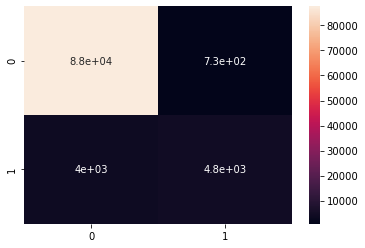

In [159]:
cf_matrix = metrics.confusion_matrix(y_test, boosting_model.predict(x_test) > 0.5)
sns.heatmap(cf_matrix, annot=True);

In [160]:
print(f'Average precision: {metrics.average_precision_score(y_test, boosting_model.predict(x_test)):.3f}')

Average precision: 0.700


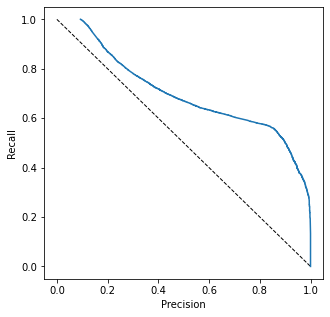

In [161]:
precision, recall, _ = metrics.precision_recall_curve(y_test, boosting_model.predict(x_test))

plt.figure(figsize=(5, 5))
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.plot(np.linspace(0, 1, 100), 1-np.linspace(0, 1, 100), linestyle='--', linewidth=1, color='black')
plt.plot(precision, recall)
plt.show()

## Check the feature importances

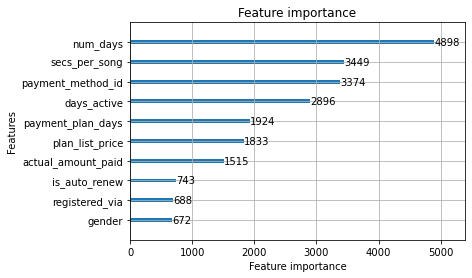

In [162]:
lgb.plot_importance(boosting_model)
plt.show()